# Imports and configuration

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from mpl_toolkits.mplot3d import axes3d
from xgboost import XGBClassifier
from datetime import date
from sklearn.metrics import precision_recall_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, roc_curve, auc, accuracy_score, classification_report, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Will allow us to embed images in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 3)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

r = 666
np.set_printoptions(precision=2)
np.random.seed(r)
# Remember to call np.random.seed(r) before every function that uses np.random

C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading original dataset

In [4]:
dataset = pd.read_csv('../common/dataset.csv', header=0, index_col='CUST_COD')
target = pd.read_csv('../common/target.csv', header=0, index_col='CUST_COD')
print(dataset.shape)
print(target.shape)

(26884, 24)
(3116, 24)


In [7]:
dataset.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,BIRTH_DATE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,...,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
CUST_COD,,,,,,,,,,,,,,,,,,,,,
53613503,1490.680,M,university,single,NaN,0,0,0,0,2,...,629.156401,599.283174,608.257067,89.440800,149.06800,68.571280,0.000000,29.81360,59.627200,0
35524089,5664.584,M,university,married,04/01/1983,0,0,0,0,0,...,533.872135,-2.772665,-14.399969,149.068000,159.83071,29.813600,0.000000,0.00000,0.000000,1
58777007,6260.856,F,high school,married,02/01/1975,0,0,-1,-1,-2,...,-19.349026,-19.349026,-19.349026,59.627200,532.59015,16.963938,0.000000,0.00000,29.813600,0
26913418,8944.080,F,graduate school,married,15/01/1977,-2,-2,-2,-2,-2,...,88.546392,70.330282,253.177091,80.556347,217.22189,88.784901,70.628418,298.46395,216.416922,0
41993633,3577.632,F,graduate school,married,09/01/1978,-1,-1,-1,-1,-1,...,0.000000,569.439760,0.000000,119.254400,29.81360,0.000000,569.439760,0.00000,0.000000,1


In [8]:
dataset.describe()

,LIMIT_BAL,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,BILL_AMT_NOV,BILL_AMT_OCT,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
count,26884.00000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000
mean,4997.91411,-0.016367,-0.133313,-0.166344,-0.219052,-0.264879,-0.291884,1530.136656,1467.012379,1404.166272,1292.346498,1203.977907,1159.529034,168.639427,178.825861,156.416357,144.518815,144.259750,157.534344,0.221098
std,3879.73624,1.123991,1.197715,1.197837,1.171221,1.135089,1.150547,2206.111841,2129.923058,2072.220534,1923.241494,1816.137779,1775.876050,495.392694,688.001298,531.588567,465.903631,463.780141,538.637089,0.414994
min,298.13600,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-4936.535888,-2080.303567,-4688.605990,-2424.859342,-2424.859342,-10124.788000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1490.68000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,105.115300,87.622170,79.535231,68.951403,52.553923,37.594950,29.634718,24.879449,11.627304,8.884453,7.870790,3.637259,0.000000
50%,4173.90400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,667.198554,631.705464,599.491869,568.008707,539.998830,506.920641,62.608560,60.044590,54.260752,44.720400,44.720400,44.720400,0.000000
75%,7155.26400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1997.891324,1905.320095,1798.386166,1629.998953,1504.528417,1473.179417,149.276695,149.068000,134.369895,119.709057,120.379863,119.321481,0.000000
max,29813.60000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,28755.545150,29334.525260,49612.483810,26581.388370,27642.305330,28670.665830,26043.729910,50213.824120,26714.178140,18514.245600,12716.364990,15761.436660,1.000000


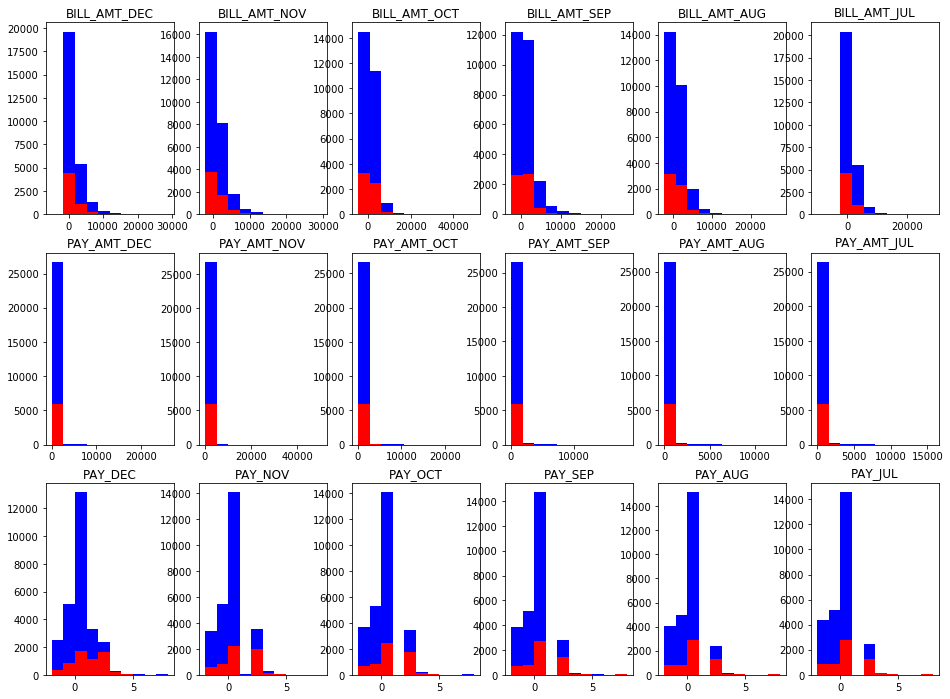

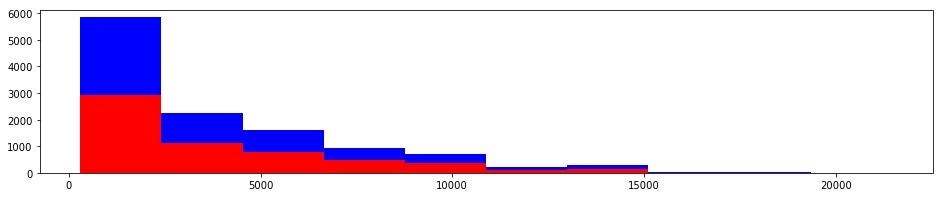

In [11]:
X = dataset

cols = [  'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL',
             'PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
# 13 fields
i = 1

ones_mask = X['DEFAULT PAYMENT JAN'] == 1
zeros_mask = X['DEFAULT PAYMENT JAN'] == 0

fig = plt.figure(figsize=(16, 3 * 4))
for col in cols:
    ax = fig.add_subplot(3,6,i)
    i += 1
    ax.set_title(col)
    ones = X[col][ones_mask]
    zeros = X[col][zeros_mask]
    ax.hist((ones, zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
    #ax.legend(loc='best')
plt.show() 

plt.figure()
ones = X['LIMIT_BAL'][ones_mask]
zeros = X['LIMIT_BAL'][ones_mask]
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
#plt.legend(loc='best')
plt.show() 

# Different datasets management
- split_and_add
- add_dataset
- retrieve_dataset

In [13]:
X_dict = {}
y_dict = {}
X_test_dict = {}
y_test_dict = {}
X_target_dict = {}

names = set()
target_col_name = 'DEFAULT PAYMENT JAN'

def split_and_add(name, dataset, target):
    train, test = train_test_split(dataset, test_size=0.33, random_state=r, stratify=dataset[target_col_name])
    X = train.drop([target_col_name], 1)
    y = train[target_col_name]
    X_test = test.drop([target_col_name], 1)
    y_test = test[target_col_name]
    X_target = target.drop(target_col_name, 1)
    add_dataset(name, X, y, X_test, y_test, X_target)
    print('Train X shape: {}'.format(X.shape))
    print('Test X shape: {}'.format(X_test.shape))
    print('Target X shape: {}'.format(X_target.shape))

def add_dataset(name, X, y, X_test, y_test, X_target):
    names.add(name)
    X_dict[name] = X
    y_dict[name] = y
    X_test_dict[name] = X_test
    y_test_dict[name] = y_test
    X_target_dict[name] = X_target

def retrieve_dataset(name):
    return (X_dict[name], y_dict[name], X_test_dict[name], y_test_dict[name], X_target_dict[name])

split_and_add('orig', dataset, target)

non_numerical_features = ['SEX', 'EDUCATION', 'MARRIAGE', 'BIRTH_DATE']
split_and_add('baseline', dataset.drop(non_numerical_features, 1), target.drop(non_numerical_features, 1))

X, y, X_test, y_test, X_target = retrieve_dataset('baseline')
rs = RobustScaler()
rs.fit(X)
X = pd.DataFrame(rs.transform(X), index=X.index, columns=X.columns)
X_test = pd.DataFrame(rs.transform(X_test), index=X_test.index, columns=X_test.columns)
add_dataset('baseline_scaled', X, y, X_test, y_test, X_target)

Train X shape: (18012, 23)
Test X shape: (8872, 23)
Target X shape: (3116, 23)
Train X shape: (18012, 19)
Test X shape: (8872, 19)
Target X shape: (3116, 19)


# Alessandro's dataset
- One hot encoding of SEX
- scores to MARRIAGE and EDUCATION
- BIRTH_DATE transformed to AGE and normalized
- Columns with money values like LIMIT_BAL and BILL_AMT_DEC normalized togheter to mean=0 std=1
- Delay in payments normalized togheter to mean=0 std=1

In [14]:
def transform_features(X_orig):
    X = X_orig.copy()

    # print('One hot encoding SEX feature')
    # set(dataset["SEX"]) = {nan, 'M', 'F'}
    fields = ['SEX']
    for field in fields:
        X = pd.concat([X.drop([field], 1), pd.get_dummies(X[field])], axis=1)

    # print('Scoring EDUCATION and MARRIAGE features')
    # Assume other == Nan
    # set(dataset["EDUCATION"]) = {nan, 'high school', 'graduate school', 'other§', 'university'}
    # set(dataset["MARRIAGE"]) = {nan, 'other', 'single', 'married'}
    education_dict = {'other': 0, 'high school': 0.25, 'university': 0.75, 'graduate school': 1}
    X['EDUCATION'] = X['EDUCATION'].fillna('other').apply(lambda x: education_dict[x])
    marriage_dict = {'other': 0, 'single': 0.5, 'married': 1}
    X['MARRIAGE'] = X['MARRIAGE'].fillna('other').apply(lambda x: marriage_dict[x])

    #print('Computing AGE and dropping BIRTH_DATE')
    # Target: Year-Month-DayTTime
    X['BIRTH_DATE'] = pd.to_datetime(X['BIRTH_DATE'])
    def calculate_age(birth_date):
        today = date.today()
        age = today.year - birth_date.year
        full_year_passed = (today.month, today.day) < (birth_date.month, birth_date.day)
        if not full_year_passed:
            age -= 1
        return age
    X['AGE'] = X['BIRTH_DATE'].apply(lambda x: calculate_age(x))
    X = X.drop(["BIRTH_DATE"], 1)
    X['AGE'] = X['AGE'].fillna(X['AGE'].median())
    
    fields = ['LIMIT_BAL',
              'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']

    # print('Normalizing € fields')
    X[fields] = X[fields].apply(lambda x: np.cbrt(x))
    # np.cbrt is the only one that works with negative numbers
    # using pow with 1/3 or 1/5 etc with negative numbers leads to complex number as results because of
    # numerical approximations
    # np.cbrt instead apply the direct algorithm to find cubic root, which is well defined for every negative numbe
    
    # print('Dataset prepared')
    # print(X.shape)
    
    return X.copy()

X, y, X_test, y_test, X_target = retrieve_dataset(name='orig')
add_dataset('ale', transform_features(X), y, transform_features(X_test), y_test, transform_features(X_target))
X, y, X_test, y_test, X_target = retrieve_dataset(name='ale')
X.head(5)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,13.360872,0.75,0.5,1,2,2,2,2,-2,4.951950,...,0.000000,0.000000,5.119281,0.855483,0.000000,0.000000,0.000000,1,0,28.0
21308338,8.416822,1.00,0.5,0,0,0,0,0,0,7.777672,...,8.427890,5.302266,3.906743,3.549511,3.100784,2.615302,3.100784,1,0,23.0
54049646,17.507695,0.25,1.0,0,0,0,0,0,0,14.005143,...,13.631800,4.877483,5.302972,4.546873,5.302266,4.490414,4.569354,1,0,49.0
10396398,9.634856,0.25,0.5,-1,-1,-2,-2,-2,-2,2.706525,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,50.0
11528589,14.857157,0.75,1.0,0,0,0,0,0,0,11.382419,...,10.220138,4.475580,4.472104,4.472104,4.472104,4.922187,4.472104,0,1,40.0


In [15]:
X.describe().round(3)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,...,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,15.837,0.745,0.719,-0.009,-0.129,-0.162,-0.211,-0.256,-0.285,8.935,...,7.692,4.042,4.000,3.738,3.561,3.532,3.524,0.595,0.396,35.638
std,4.610,0.268,0.260,1.122,1.191,1.195,1.176,1.143,1.158,5.485,...,5.456,2.693,2.769,2.733,2.729,2.706,2.868,0.491,0.489,9.082
min,6.680,0.000,0.000,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-17.027,...,-21.634,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,21.000
25%,11.423,0.750,0.500,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,4.830,...,3.341,3.101,2.913,2.265,2.042,1.956,1.489,0.000,0.000,29.000
50%,16.101,0.750,0.500,0.000,0.000,0.000,0.000,0.000,0.000,8.856,...,8.017,3.971,3.916,3.791,3.550,3.550,3.550,1.000,0.000,34.000
75%,19.270,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,12.646,...,11.391,5.304,5.302,5.119,4.925,4.930,4.922,1.000,1.000,41.000
max,28.172,1.000,1.000,8.000,7.000,8.000,7.000,7.000,8.000,28.133,...,25.057,24.693,33.197,24.745,23.443,23.184,25.073,1.000,1.000,75.000


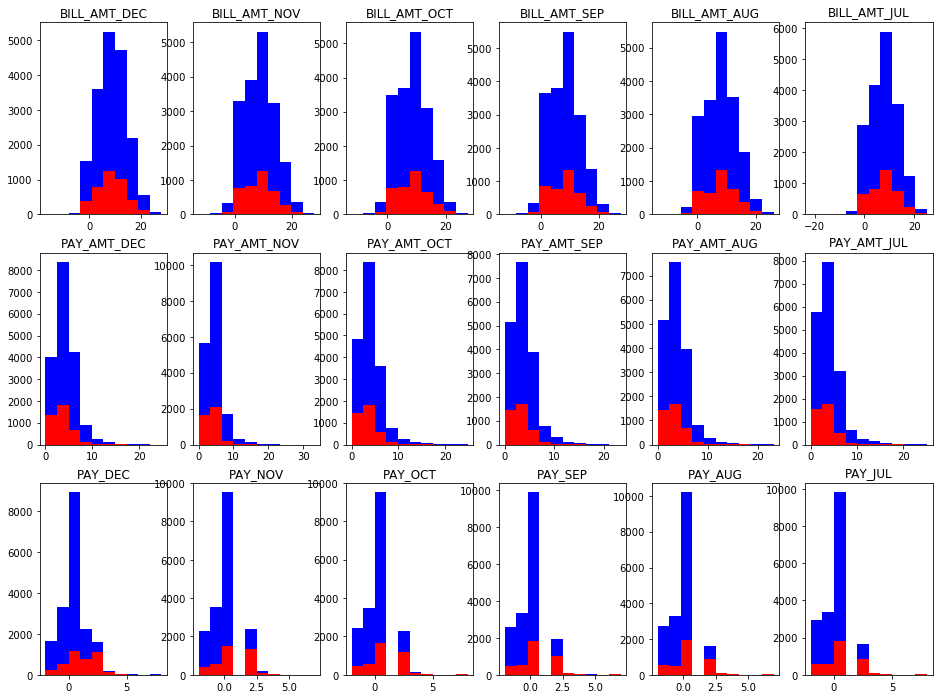

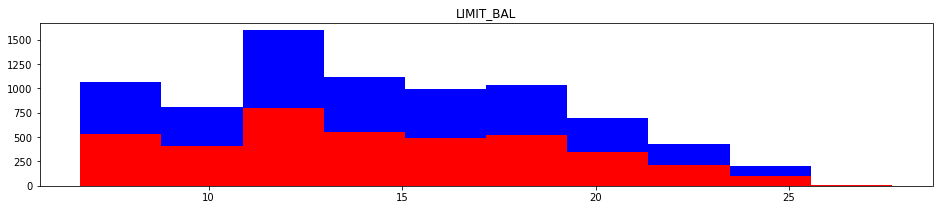

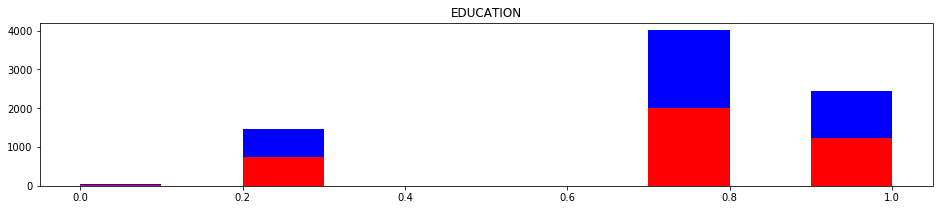

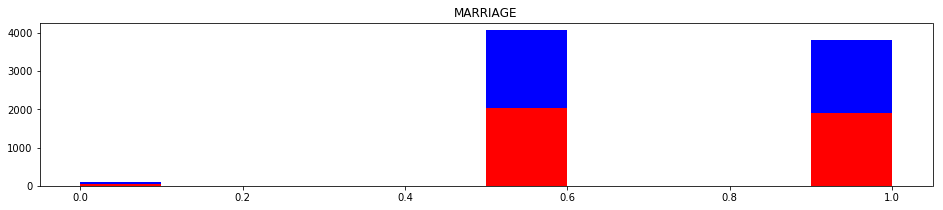

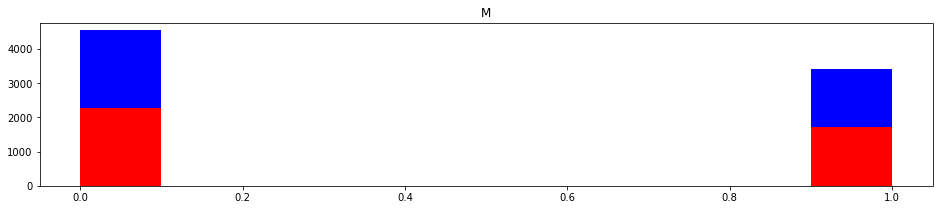

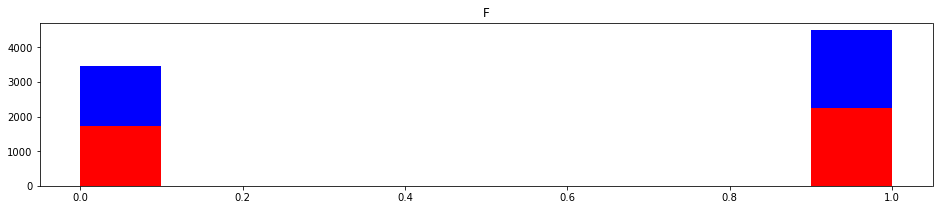

In [17]:
X, y, _, _, _ = retrieve_dataset(name='ale')

cols = [  'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL',
             'PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
# 13 fields
i = 1

ones_mask = y == 1
zeros_mask = y == 0

fig = plt.figure(figsize=(16, 3 * 4))
for col in cols:
    ax = fig.add_subplot(3,6,i)
    i += 1
    ax.set_title(col)
    ones = X[col][ones_mask]
    zeros = X[col][zeros_mask]
    ax.hist((ones, zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show() 

plt.figure()
ones = X['LIMIT_BAL'][ones_mask]
zeros = X['LIMIT_BAL'][ones_mask]
plt.title('LIMIT_BAL')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

plt.figure()
ones = X['EDUCATION'][ones_mask]
zeros = X['EDUCATION'][ones_mask]
plt.title('EDUCATION')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

plt.figure()
ones = X['MARRIAGE'][ones_mask]
zeros = X['MARRIAGE'][ones_mask]
plt.title('MARRIAGE')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

plt.figure()
ones = X['M'][ones_mask]
zeros = X['M'][ones_mask]
plt.title('M')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

plt.figure()
ones = X['F'][ones_mask]
zeros = X['F'][ones_mask]
plt.title('F')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

# Dataset Creation - ale_scaled

In [19]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale')
rs = RobustScaler()
rs.fit(X)
X_scaled = pd.DataFrame(rs.transform(X), columns=X.columns, index=X.index)
X_test_scaled = pd.DataFrame(rs.transform(X_test), columns=X_test.columns, index=X_test.index)
X_target_scaled = pd.DataFrame(rs.transform(X_target), columns=X_target.columns, index=X_target.index)
add_dataset('ale_scaled', X_scaled, y, X_test_scaled, y_test, X_target_scaled)
X_scaled.head(5)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,-0.349199,0.0,0.0,1.0,2.0,2.0,2.0,2.0,-2.0,-0.499532,...,-0.995851,-1.802536,0.503453,-1.028644,-1.231275,-1.193516,-1.033907,0.0,0.0,-0.500000
21308338,-0.979309,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.137981,...,0.051072,0.604417,-0.004078,-0.084631,-0.155657,-0.314126,-0.130706,0.0,0.0,-0.916667
54049646,0.179306,-2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.658823,...,0.697508,0.411587,0.580341,0.264854,0.608005,0.316377,0.297061,0.0,0.0,1.250000
10396398,-0.824073,-2.0,0.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-0.786834,...,-0.995851,-1.802536,-1.639320,-1.328413,-1.231275,-1.193516,-1.033907,0.0,0.0,1.333333
11528589,-0.158500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323245,...,0.273707,0.229144,0.232565,0.238655,0.320034,0.461559,0.268734,-1.0,1.0,0.500000


In [20]:
if False:
    X, y, X_test, y_test, _ = retrieve_dataset('ale_scaled')
    pd.concat([X, y], axis=1).to_csv('train.csv', index=False)
    pd.concat([X_test, y_test], axis=1).to_csv('test.csv', index=False)

In [21]:
X_scaled.describe().round(3)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,...,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,-0.034,-0.022,0.438,-0.009,-0.129,-0.162,-0.211,-0.256,-0.285,0.010,...,-0.040,0.032,0.035,-0.018,0.004,-0.006,-0.007,-0.405,0.396,0.136
std,0.588,1.072,0.521,1.122,1.191,1.195,1.176,1.143,1.158,0.702,...,0.678,1.223,1.159,0.958,0.947,0.910,0.835,0.491,0.489,0.757
min,-1.201,-3.000,-1.000,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-3.312,...,-3.683,-1.803,-1.639,-1.328,-1.231,-1.194,-1.034,-1.000,0.000,-1.083
25%,-0.596,0.000,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-0.515,...,-0.581,-0.395,-0.420,-0.535,-0.523,-0.536,-0.600,-1.000,0.000,-0.417
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,...,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.404,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.485,...,0.419,0.605,0.580,0.465,0.477,0.464,0.400,0.000,1.000,0.583
max,1.539,1.000,1.000,8.000,7.000,8.000,7.000,7.000,8.000,2.466,...,2.117,9.407,12.256,7.343,6.901,6.602,6.269,0.000,1.000,3.417


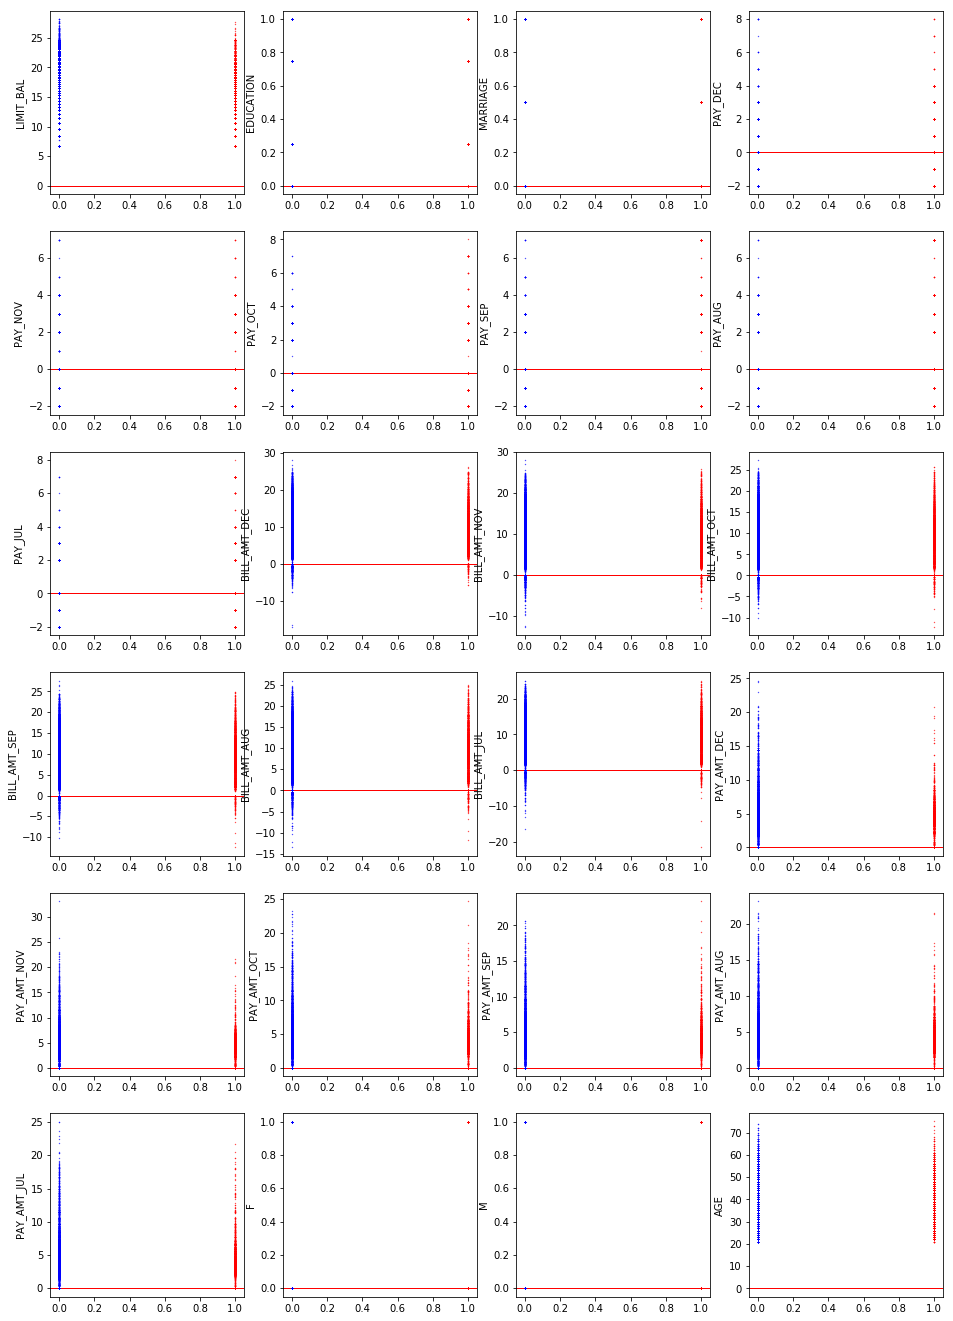

In [22]:
X, y, _, _, _ = retrieve_dataset('ale')
i = 1
fig = plt.figure(figsize=(16, 12 * 4))
for col_name in X.columns:
    ax = fig.add_subplot(12, 4, i)
    i += 1
    ax.set_ylabel(col_name)
    ax.scatter(y[y==1], X[col_name][y == 1], c='r', s=0.1)
    ax.scatter(y[y==0], X[col_name][y == 0], c='b', s=0.1)
    ax.axhline(y=0, c='red', linewidth=1, zorder=0)
plt.show()

# Plot confusion matrix function

In [25]:
classes = ['0', '1']

def plot_confusion_matrix(cm, classes=classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Preliminary Prediction Tests

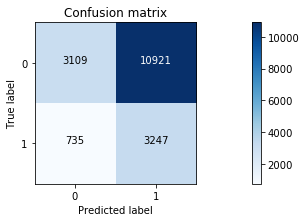

             precision    recall  f1-score   support

          0       0.81      0.22      0.35     14030
          1       0.23      0.82      0.36      3982

avg / total       0.68      0.35      0.35     18012



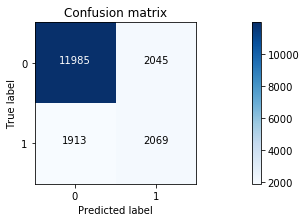

             precision    recall  f1-score   support

          0       0.86      0.85      0.86     14030
          1       0.50      0.52      0.51      3982

avg / total       0.78      0.78      0.78     18012



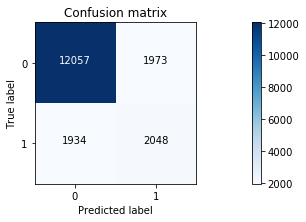

             precision    recall  f1-score   support

          0       0.86      0.86      0.86     14030
          1       0.51      0.51      0.51      3982

avg / total       0.78      0.78      0.78     18012



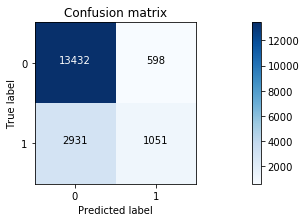

             precision    recall  f1-score   support

          0       0.82      0.96      0.88     14030
          1       0.64      0.26      0.37      3982

avg / total       0.78      0.80      0.77     18012



In [27]:
X, y, _, _, _ = retrieve_dataset(name='orig')

y_pred = X['PAY_AMT_DEC'] < X['BILL_AMT_DEC']
plot_confusion_matrix(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
plot_confusion_matrix(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
y_pred &= (X['PAY_AMT_DEC'] < X['BILL_AMT_DEC'] + 1000)
y_pred &= (X['PAY_AMT_NOV'] < X['BILL_AMT_NOV'] + 1000)
y_pred &= (X['PAY_AMT_OCT'] < X['BILL_AMT_OCT'] + 1000)
plot_confusion_matrix(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
y_pred &= (X['PAY_NOV'] > 0)
y_pred &= (X['PAY_OCT'] > 0)
plot_confusion_matrix(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

# PAY_AMT vs Month, BILL_AMT vs Month

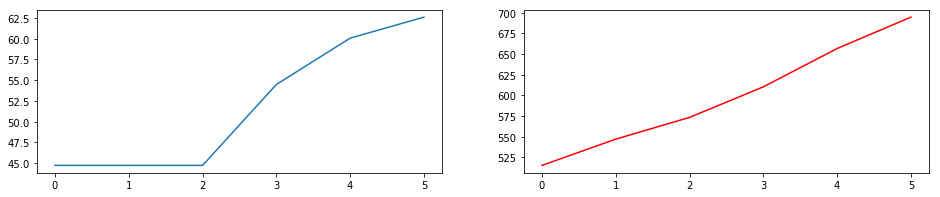

In [28]:
X, y, _, _, _ = retrieve_dataset(name='orig')
months = ['JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

m = [X['PAY_AMT_{}'.format(month)].median() for month in months]

fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 2, 1)
ax.plot(m)
m = [X['BILL_AMT_{}'.format(month)].median() for month in months]
ax = fig.add_subplot(1, 2, 2)
ax.plot(m, c='r')

plt.show()

# 2D PCA - ale_scaled

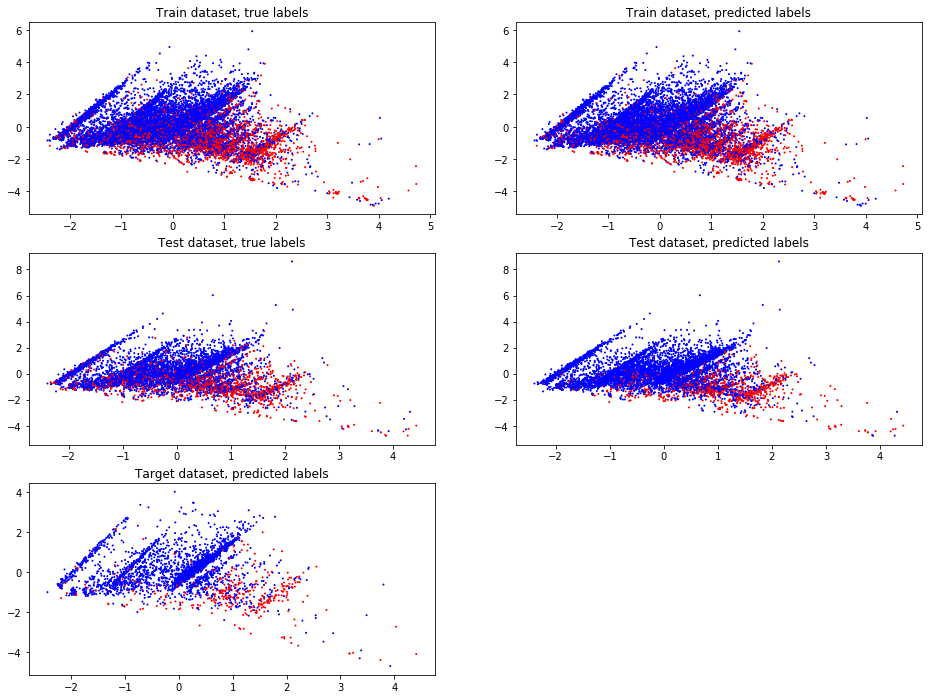

In [29]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale_scaled')

colors = {0: 'b', 1: 'r'}
sizes = {0: 1, 1: 1}

def color(y):
    return pd.Series(y).apply(lambda x: colors[x])
def size(y):
    return pd.Series(y).apply(lambda x: sizes[x])

pca = PCA(whiten=True, random_state=r, n_components=2)
pca.fit(X)

X_tf = pd.DataFrame(pca.transform(X), index=X.index)

# clf = XGBClassifier(scale_pos_weight=3)
clf = RandomForestClassifier()
clf.fit(X_tf, y)

y_pred = clf.predict(X_tf)

X_test_tf = pd.DataFrame(pca.transform(X_test), index=X_test.index)
y_test_pred = clf.predict(X_test_tf)

X_target_tf = pd.DataFrame(pca.transform(X_target), index=X_target.index)
y_target_pred = clf.predict(X_target_tf)

fig = plt.figure(figsize=(16, 3 * 4))

ax = fig.add_subplot(3, 2, 1)
ax.set_title('Train dataset, true labels')
ax.scatter(X_tf[0], X_tf[1], c=color(y), s=size(y))

ax = fig.add_subplot(3, 2, 2)
ax.set_title('Train dataset, predicted labels')
ax.scatter(X_tf[0], X_tf[1], c=color(y_pred), s=size(y_pred))

ax = fig.add_subplot(3, 2, 3)
ax.set_title('Test dataset, true labels')
ax.scatter(X_test_tf[0], X_test_tf[1], c=color(y_test), s=size(y_test))

ax = fig.add_subplot(3, 2, 4)
ax.set_title('Test dataset, predicted labels')
ax.scatter(X_test_tf[0], X_test_tf[1], c=color(y_test_pred), s=size(y_test_pred))

# No true labels on target dataset

ax = fig.add_subplot(3, 2, 5)
ax.set_title('Target dataset, predicted labels')
ax.scatter(X_target_tf[0], X_target_tf[1], c=color(y_target_pred), s=size(y_target_pred))

plt.show()

# 3D PCA - ale_scaled

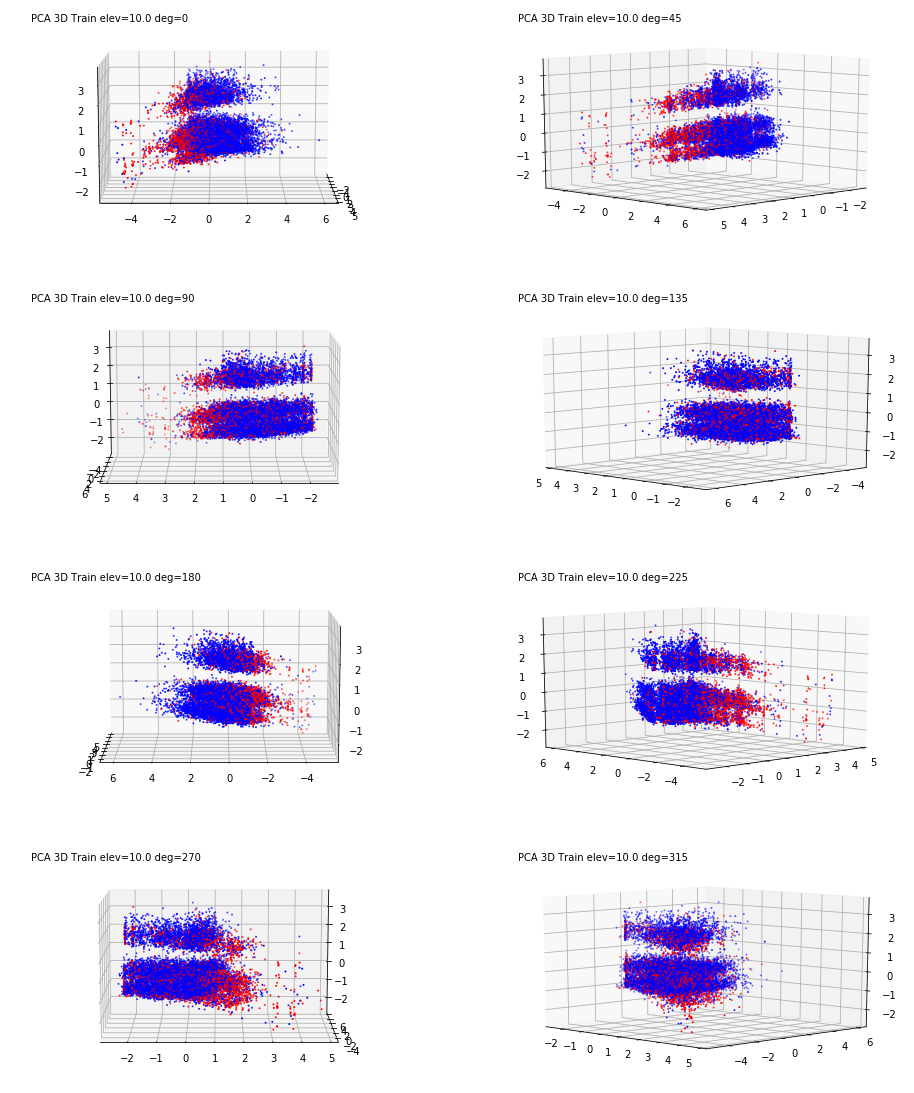

In [30]:
X, y, _, _, _ = retrieve_dataset('ale_scaled')

colors = {0: 'b', 1: 'r', 2: 'y'}
sizes = {0: 1, 1: 1}
c = y.apply(lambda x: colors[x])
s = y.apply(lambda x: sizes[x])

pca = PCA(whiten=True, random_state=r, n_components=3)
pca.fit(X)
df = pd.DataFrame(pca.transform(X), index=X.index)
# kmeans = KMeans(n_clusters=5, random_state=r, copy_x=True, n_jobs=-1).fit(df)
# c = list(map(lambda x: 'C{}'.format(x), list(kmeans.predict(df))))
fig = plt.figure(figsize=(16, 6 * 5))
for ii in np.arange(0, 360, 45):
    ax = fig.add_subplot(6, 2, ii / 45 + 1, projection='3d')
    ax.text2D(0.05, 0.95, 'PCA 3D Train elev={} deg={}'.format(10., ii), transform=ax.transAxes)
    ax.view_init(elev=10., azim=ii)
    ax.scatter(df[0], df[1], df[2], c=c, s=s)
plt.show()

# PCA - tresh = 0.95

Starting PCA
cumsum_tresh = 0.8, n_components = 7
cumsum_tresh = 0.85, n_components = 9
cumsum_tresh = 0.9, n_components = 11
cumsum_tresh = 0.95, n_components = 13
cumsum_tresh = 0.97, n_components = 15
cumsum_tresh = 0.99, n_components = 18


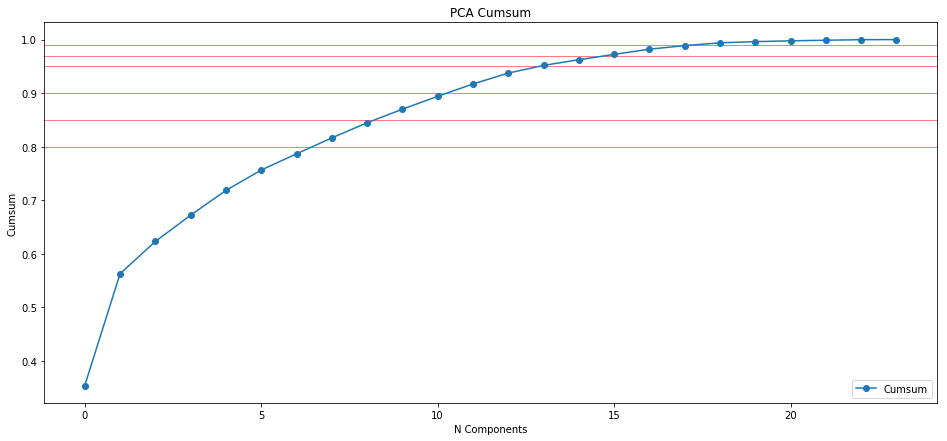

Selecting tresh = 0.95 -> n_components = 13


In [40]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale_scaled')

print('Starting PCA')
pca = PCA(whiten=True, random_state=r)
pca.fit(X)

cumsum = sorted(list(pca.explained_variance_ratio_.cumsum()))

def find_cumsum_tresh(cumsum, cumsum_tresh):
    for i in np.arange(0, len(cumsum)):
        if cumsum[i] >= cumsum_tresh:
            break
    return i

plt.figure(figsize=(16, 7))
plt.plot(cumsum, label='Cumsum', marker='o')
plt.xlabel('N Components')
plt.ylabel('Cumsum')
plt.title('PCA Cumsum')
plt.legend(loc='best')

for i in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99]:
    n_components = find_cumsum_tresh(cumsum, i)
    print('cumsum_tresh = {}, n_components = {}'.format(i, n_components))
    plt.axhline(y=i, c='red', linewidth=0.5, zorder=0)

plt.show()

tresh = 0.95

n_components = find_cumsum_tresh(cumsum, tresh)
print('Selecting tresh = {} -> n_components = {}'.format(tresh, n_components))
pca = PCA(whiten=True, random_state=r, n_components=n_components)
pca.fit(X)

X_pca = pd.DataFrame(pca.transform(X), index=X.index)
X_pca_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)
X_pca_target = pd.DataFrame(pca.transform(X_target), index=X_target.index)

add_dataset('ale_pca', X_pca, y, X_pca_test, y_test, X_pca_target)

In [41]:
X, y, _, _, _ = retrieve_dataset('ale_pca')
X.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12
CUST_COD,,,,,,,,,,,,,
14356766,0.540171,-2.001263,-0.413164,0.067173,-0.385130,2.777774,0.102990,0.153965,2.147737,-0.434474,1.141047,-1.756073,-0.760934
21308338,0.143601,-0.117642,-1.149513,0.682112,0.334347,0.251100,-1.084849,0.791565,0.045176,-0.004040,-0.124422,-0.306684,-0.206986
54049646,0.575811,0.571203,2.072468,-0.361788,-0.267010,-0.294327,0.387282,-0.131235,-0.469041,-0.622190,-0.882898,-0.650389,-0.137471
10396398,-1.933771,-1.034495,2.126712,-0.492230,-0.131902,-0.138400,-0.178778,0.001580,-0.218616,-0.919011,-0.413622,-0.313915,-0.078621
11528589,0.330819,0.267248,0.135631,-0.125620,-0.091237,-0.261799,0.706830,-0.564479,-0.087986,-0.003561,0.438618,0.861461,0.178521


In [42]:
X.describe().round(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-2.437,-4.872,-2.477,-5.026,-5.832,-6.107,-4.267,-4.939,-5.339,-4.319,-4.405,-4.397,-5.892
25%,-0.683,-0.631,-0.766,-0.498,-0.435,-0.434,-0.667,-0.606,-0.540,-0.711,-0.671,-0.699,-0.467
50%,0.193,-0.061,-0.180,0.011,-0.022,-0.020,-0.058,0.027,-0.064,-0.177,-0.037,-0.113,-0.008
75%,0.630,0.599,0.255,0.481,0.376,0.424,0.618,0.612,0.501,0.617,0.624,0.790,0.428
max,4.732,5.912,3.442,5.713,6.218,8.069,4.863,5.442,7.522,6.003,5.114,4.465,8.368


In [46]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale_scaled')
kmeans = KMeans(random_state=r, n_clusters=4, n_jobs=-1)
kmeans.fit(X)
X = pd.concat([X, pd.get_dummies(pd.Series(kmeans.predict(X), index=X.index), prefix='CLUSTER')], axis=1)
X_test = pd.concat([X_test, pd.get_dummies(pd.Series(kmeans.predict(X_test), index=X_test.index), prefix='CLUSTER')], axis=1)
X_target = pd.concat([X_target, pd.get_dummies(pd.Series(kmeans.predict(X_target), index=X_target.index), prefix='CLUSTER')], axis=1)
add_dataset('ale_kmeans', X, y, X_test, y_test, X_target)
X.head(5)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE,CLUSTER_0,CLUSTER_1,CLUSTER_2,CLUSTER_3
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,-0.349199,0.0,0.0,1.0,2.0,2.0,2.0,2.0,-2.0,-0.499532,...,-1.231275,-1.193516,-1.033907,0.0,0.0,-0.500000,0,0,1,0
21308338,-0.979309,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.137981,...,-0.155657,-0.314126,-0.130706,0.0,0.0,-0.916667,1,0,0,0
54049646,0.179306,-2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.658823,...,0.608005,0.316377,0.297061,0.0,0.0,1.250000,0,0,0,1
10396398,-0.824073,-2.0,0.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-0.786834,...,-1.231275,-1.193516,-1.033907,0.0,0.0,1.333333,0,1,0,0
11528589,-0.158500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323245,...,0.320034,0.461559,0.268734,-1.0,1.0,0.500000,1,0,0,0


# CV and scoring functions

In [47]:
cv = StratifiedKFold(n_splits=10, random_state=r, shuffle=True)

# DISABLED - Undersample and Oversample

In [48]:
if False:
    X, y, X_test, y_test, X_target = retrieve_dataset('ale_scaled')
    i = 0
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    #clf = MLPClassifier(hidden_layer_sizes=(9,7), validation_fraction=0.1, random_state=r)
    #clf = XGBClassifier(seed=r)
    clf = RandomForestClassifier(random_state=r, n_jobs=-1, n_estimators=300, max_depth=3, max_features=4)
    # clf = LogisticRegression(penalty='l2', C=10, fit_intercept=True, random_state=r, n_jobs=-1)
    # clf = ExtraTreesClassifier(n_estimators=100)
    f1s = []
    np.random.seed(r)
    def under_sample(y, train):
        y_train_fold = y[train]
        n = y_train_fold.count()
        n_ones = y_train_fold.sum()
        n_zeros = n - n_ones
        train_ones = train[y_train_fold == 1]
        train_zeros = train[y_train_fold == 0]
        train_zeros = np.setdiff1d(train_zeros, np.random.choice(train_zeros, n_zeros - n_ones, replace=False))
        return np.append(train_ones, train_zeros)

    #from imblearn.over_sampling import SMOTE
    #sm = SMOTE(random_state=r, kind='svm', n_jobs=-1)

    for train, test in cv.split(X, y):
        train = under_sample(y, train)
        clf.fit(X.iloc[train], y.iloc[train])

        #X_fold_train = X.iloc[train]
        #y_fold_train = y.iloc[train]
        #X_res, y_res = sm.fit_sample(X_fold_train, y_fold_train)
        #X_res = pd.DataFrame(X_res, columns=X.columns)

        y_pred = clf.predict(X.iloc[test])
        f1 = f1_score(y[test], y_pred)
        f1s.append(f1)
        print('fold {}, f1 {}, accuracy {}'.format(i, f1, accuracy_score(y[test], y_pred)))
        i += 1

    print('f1 {} +- {}'.format(np.mean(f1s), np.std(f1s)))

# Cross validate and score

In [181]:
def cv_clf(clf, tresholds, X, y):
    probas = []
    trues = []
    preds = []
    for train, test in cv.split(X, y):
        clf.fit(X.iloc[train], y.iloc[train])
        probas.append(clf.predict_proba(X.iloc[test])[:,1])
        trues.append(y.iloc[test])
    
    if (len(tresholds) == 1):
        best_t = tresholds[0]
    else:
        best_t = -1
        best_f1 = -1
        for t in sorted(tresholds):
            f1s = []
            accs = []
            precs = []
            recs = []
            for i in np.arange(len(probas)):
                y_true = trues[i]
                y_pred = pd.Series(probas[i]).apply(lambda x: 1 if x >= t else 0)

                f1s.append(f1_score(y_true, y_pred))
                accs.append(accuracy_score(y_true, y_pred))
                precs.append(precision_score(y_true, y_pred))
                recs.append(recall_score(y_true, y_pred))
            curr_f1 = np.mean(f1s)
            if (curr_f1 > best_f1):
                best_f1 = curr_f1
                best_t = t
                if False:
                    print('New best t = {}!'.format(t))
                    print('f1_cv = {:.3f} ± {:.3f}'.format(np.mean(f1s), np.std(f1s)))
                    print('acc_cv = {:.3f} ± {:.3f}'.format(np.mean(accs), np.std(accs)))
                    print('prec_cv = {:.3f} ± {:.3f}'.format(np.mean(precs), np.std(precs)))
                    print('rec_cv = {:.3f} ± {:.3f}'.format(np.mean(recs), np.std(recs)))    
        
    f1s = []
    accs = []
    precs = []
    recs = []
    for i in np.arange(len(probas)):
        y_true = trues[i]
        y_pred = pd.Series(probas[i]).apply(lambda x: 1 if x >= best_t else 0)

        f1s.append(f1_score(y_true, y_pred))
        accs.append(accuracy_score(y_true, y_pred))
        precs.append(precision_score(y_true, y_pred))
        recs.append(recall_score(y_true, y_pred))
    print('Cross validation report')
    print('Threshold = {}'.format(best_t))
    print('f1_cv = {:.3f} ± {:.3f}'.format(np.mean(f1s), np.std(f1s)))
    print('acc_cv = {:.3f} ± {:.3f}'.format(np.mean(accs), np.std(accs)))
    print('prec_cv = {:.3f} ± {:.3f}'.format(np.mean(precs), np.std(precs)))
    print('rec_cv = {:.3f} ± {:.3f}'.format(np.mean(recs), np.std(recs)))
    return best_t

def train_cv_test_score_target_pred(clf, name, tresholds=np.arange(0, 1, 0.01)):
    print('Evaluating on ' + name + ' dataset')
    X, y, X_test, y_test, X_target = retrieve_dataset(name)
    
    # Cross validate on X, y and determine best treshold
    t_best = cv_clf(clf, tresholds, X, y)
    
    # Use best threshold on cv to predict on test
    clf.fit(X, y)
        
    y_pred_test = pd.Series(clf.predict_proba(X_test)[:,1], index=X_test.index).apply(lambda x: 1 if x>=t_best else 0)
    y_pred_target = pd.Series(clf.predict_proba(X_target)[:,1], index=X_target.index).apply(lambda x: 1 if x>=t_best else 0)
    
    print('Test report')
    plot_confusion_matrix(confusion_matrix(y_test, y_pred_test))
    print('f1 = {:.3f}'.format(f1_score(y_test, y_pred_test)))
    print('acc = {:.3f}'.format(accuracy_score(y_test, y_pred_test)))
    print('prec = {:.3f}'.format(precision_score(y_test, y_pred_test)))
    print('rec = {:.3f}'.format(recall_score(y_test, y_pred_test)))  
    
    return (y_pred_test, y_pred_target)

# ROC curve function

In [192]:
def plot_roc_curve(clf, tresh, X_test, y_test):
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    # Compute ROC curve and ROC area for each class
    fpr, tpr, t = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    i = sum(tt <= tresh for tt in t)
    
    plt.figure(figsize=(16,7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr[i], tpr[i], 'ro')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Grid Search CV function

In [184]:
def grid_search_cv(parameters, clf, dataset_name='baseline', scoring='f1'):
    n_jobs = -1
    if scoring == ms:
        n_jobs = 1
    gscv = GridSearchCV(estimator=clf, param_grid=parameters, n_jobs=n_jobs, cv=cv, scoring=scoring)
    X, y, X_test, y_test, _ = retrieve_dataset(dataset_name)
    gscv.fit(X, y)
    print('GridSearchCV done on: ' + dataset_name)
    print(gscv.best_params_)
    if scoring == ms:
            scoring = 'score'
    print(scoring + ' = ' + str(gscv.best_score_))
    if len(parameters) == 1:
        plt.figure(1)
        param_name = list(parameters.keys())[0]
        if param_name == 'C':
            plt.semilogx(parameters[param_name], gscv.cv_results_['mean_test_score'], label=scoring, marker='o')
        else:
            plt.plot(parameters[param_name], gscv.cv_results_['mean_test_score'], label=scoring, marker='o')
        plt.xlabel(param_name)
        plt.ylabel(scoring)
        plt.title('CV ' + scoring)
        plt.legend(loc='best')
        plt.show()

# Dummy Classifier
baseline f1_cv = 0.362 ± 0.000 f1 0.362

Evaluating on baseline dataset
Cross validation report
Threshold = 0.0
f1_cv = 0.362 ± 0.000
acc_cv = 0.221 ± 0.000
prec_cv = 0.221 ± 0.000
rec_cv = 1.000 ± 0.000
Test report


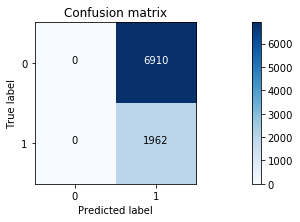

f1 = 0.362
acc = 0.221
prec = 0.221
rec = 1.000


In [185]:
clf = DummyClassifier(random_state=r)
_, _ = train_cv_test_score_target_pred(clf, 'baseline')

# NO PROBA - Linear Support Vector Classifier

In [200]:
if False: # Does not predict_proba
    clf = LinearSVC(penalty='l2',
                loss='squared_hinge',
                dual=False,
                tol=1e-4,
                C=0.01,
                fit_intercept=True,
                intercept_scaling=1.0,
                class_weight='balanced',
                verbose=0,
                random_state=r,
                max_iter=1000
               )
    _, _ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

# TOO SLOW - Support Vector Classifier

In [202]:
if False:
    clf = SVC(random_state=r, C=1)
    _, _ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

# Decision Tree Classifier
- ale_kmeans f1_cv = 0.524 ± 0.024 f1 = 0.525

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross validation report
Threshold = 0.25
f1_cv = 0.524 ± 0.024
acc_cv = 0.771 ± 0.015
prec_cv = 0.487 ± 0.029
rec_cv = 0.570 ± 0.053
Test report


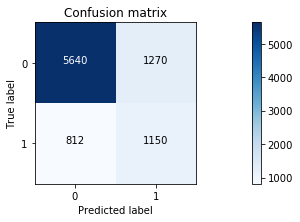

f1 = 0.525
acc = 0.765
prec = 0.475
rec = 0.586


In [206]:
clf = DecisionTreeClassifier(random_state=r, max_depth=4)
_, _ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

# Gaussian Naive Bayes
baseline f1_cv = 0.522 ± 0.016 f1 = 0.528

Evaluating on baseline dataset
Threshold = 0.48
f1_cv = 0.522 ± 0.016
acc_cv = 0.764 ± 0.010
prec_cv = 0.472 ± 0.018
rec_cv = 0.583 ± 0.024


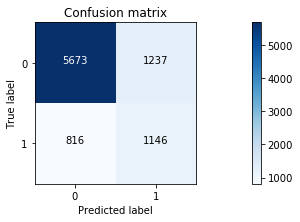

f1 = 0.528
acc = 0.769
prec = 0.481
rec = 0.584


In [178]:
# No random_state
# The priors are set based on class distribution in the dataset
# No CV needed
clf = GaussianNB()
_, _ = train_cv_test_score_target_pred(clf, 'baseline')

# Random Forest Classifier
- ale_kmeans f1_cv = 0.542 ± 0.023 f1 = 0.539

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold = 0.22
f1_cv = 0.542 ± 0.023
acc_cv = 0.777 ± 0.014
prec_cv = 0.498 ± 0.026
rec_cv = 0.596 ± 0.029


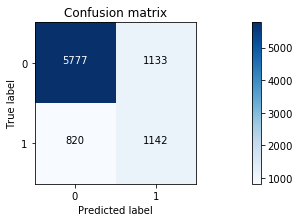

f1 = 0.539
acc = 0.780
prec = 0.502
rec = 0.582


In [158]:
clf = RandomForestClassifier(random_state=r, max_depth=3, n_jobs=-1, n_estimators=300, max_features=3)
_, _ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

Feature ranking:
1. feature PAY_DEC (0.214669)
2. feature CLUSTER_2 (0.166915)
3. feature PAY_NOV (0.149184)
4. feature PAY_OCT (0.117613)
5. feature PAY_SEP (0.076383)
6. feature PAY_AUG (0.069090)
7. feature PAY_JUL (0.050666)
8. feature PAY_AMT_DEC (0.029837)
9. feature LIMIT_BAL (0.024690)
10. feature PAY_AMT_NOV (0.017584)
11. feature CLUSTER_3 (0.013577)
12. feature PAY_AMT_SEP (0.009378)
13. feature PAY_AMT_OCT (0.009088)
14. feature PAY_AMT_AUG (0.008377)
15. feature CLUSTER_0 (0.007241)
16. feature PAY_AMT_JUL (0.006927)
17. feature BILL_AMT_NOV (0.006478)
18. feature BILL_AMT_DEC (0.004568)
19. feature BILL_AMT_OCT (0.003350)
20. feature BILL_AMT_AUG (0.003191)
21. feature BILL_AMT_JUL (0.003001)
22. feature BILL_AMT_SEP (0.002798)
23. feature CLUSTER_1 (0.002607)
24. feature EDUCATION (0.001276)
25. feature AGE (0.000925)
26. feature M (0.000312)
27. feature F (0.000140)
28. feature MARRIAGE (0.000134)


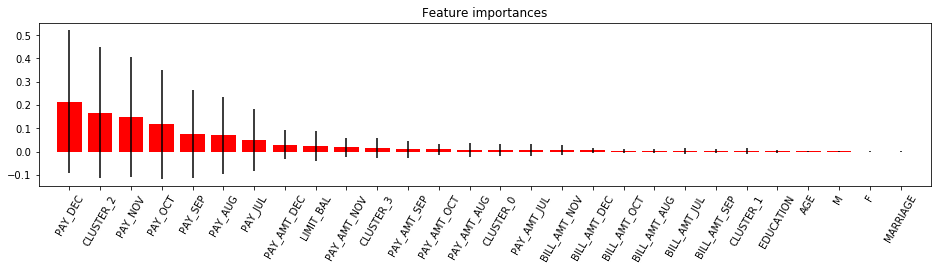

In [159]:
X, y, _, _, _ = retrieve_dataset('ale_kmeans')
forest = clf
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
l_cols = list(X.columns)
labels = [X.columns[i] for i in indices]

# Print the feature ranking
print("Feature ranking:")
for f in np.arange(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, labels[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(np.arange(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(np.arange(X.shape[1]), labels, rotation=60)
plt.xlim([-1, X.shape[1]])
plt.show()

# K Neighbors Classifier
- ale_kmeans f1_cv = 0.520 ± 0.018 v

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold = 0.31
f1_cv = 0.520 ± 0.018
acc_cv = 0.783 ± 0.010
prec_cv = 0.509 ± 0.021
rec_cv = 0.533 ± 0.021


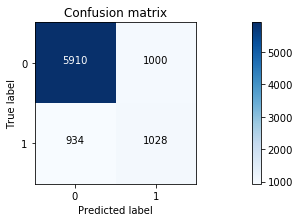

f1 = 0.515
acc = 0.782
prec = 0.507
rec = 0.524


In [177]:
clf = KNeighborsClassifier(n_neighbors=20,
                           weights='distance',
                           algorithm='auto',
                           leaf_size=30,
                           p=2,
                           metric='minkowski',
                           metric_params=None,
                           n_jobs=-1
                          )
_, _ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

# Multi Layer Perceptron Classifier
- ale: f1_cv = 0.525 ± 0.025 (24,12,8,4,2)

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold = 0.3
f1_cv = 0.533 ± 0.026
acc_cv = 0.792 ± 0.025
prec_cv = 0.538 ± 0.053
rec_cv = 0.538 ± 0.057


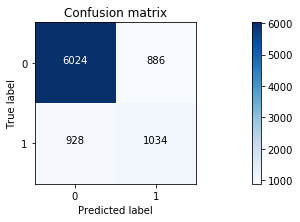

f1 = 0.533
acc = 0.796
prec = 0.539
rec = 0.527


(CUST_COD
 12458332    0
 53337233    0
 13908353    0
 50734226    0
 58776367    0
 57457139    0
 11574451    0
 31627502    0
 48408936    0
 32735550    0
 29944707    0
 18239011    0
 38965095    0
 51067841    0
 25523179    1
 44722236    0
 48943935    0
 18807262    0
 29562534    0
 43433381    0
 32435436    0
 37417554    0
 37065614    1
 15330428    0
 45588707    0
 34757838    0
 39895084    0
 19181262    0
 49933088    0
 18645093    0
            ..
 30623059    0
 52644606    0
 10597724    0
 18850079    0
 44115844    1
 56911375    0
 58607070    0
 24540725    0
 17081779    1
 47855965    0
 44982410    0
 42848634    1
 27055592    0
 35820531    0
 50986288    0
 13632704    1
 28214455    1
 38737053    0
 11478713    1
 13107164    0
 39606974    0
 45791831    0
 40834432    0
 39223004    0
 17320099    0
 31419542    0
 46470847    0
 47145511    0
 14917395    0
 52189929    0
 Length: 8872, dtype: int64, CUST_COD
 70696449    0
 76505586    0
 884425

In [162]:
clf = MLPClassifier(#hidden_layer_sizes=(24,12,8,4,2),
                    hidden_layer_sizes=(240, 120, 80, 40, 20),
                    #hidden_layer_sizes=(16,8),
                    solver='adam',
                    activation='logistic',
                    #batch_size=500,
                    validation_fraction=0.1,
                    random_state=r,
                    # verbose=False
                   )
_, _ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

# Logistic Regression
- ale_pca: f1_cv = 0.511 ± 0.018

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross validation report
Threshold = 0.25
f1_cv = 0.525 ± 0.025
acc_cv = 0.780 ± 0.013
prec_cv = 0.502 ± 0.027
rec_cv = 0.550 ± 0.024
Test report


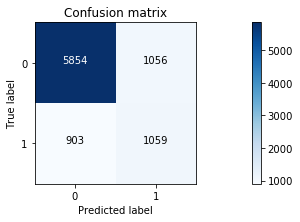

f1 = 0.519
acc = 0.779
prec = 0.501
rec = 0.540


In [198]:
clf = LogisticRegression(penalty='l1', C=1, fit_intercept=True, random_state=r, n_jobs=-1)
# grid_search_cv(parameters={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}, clf=clf, scoring='f1', dataset_name='ale_pca')
_, _ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

[[-0.18  0.04  0.14  0.44  0.08 -0.02  0.04  0.05  0.08 -0.27  0.07  0.31
   0.18 -0.23  0.12 -0.12 -0.17 -0.11 -0.05 -0.08 -0.    0.16  0.25  0.09
  -0.47  0.    0.27 -0.55]]


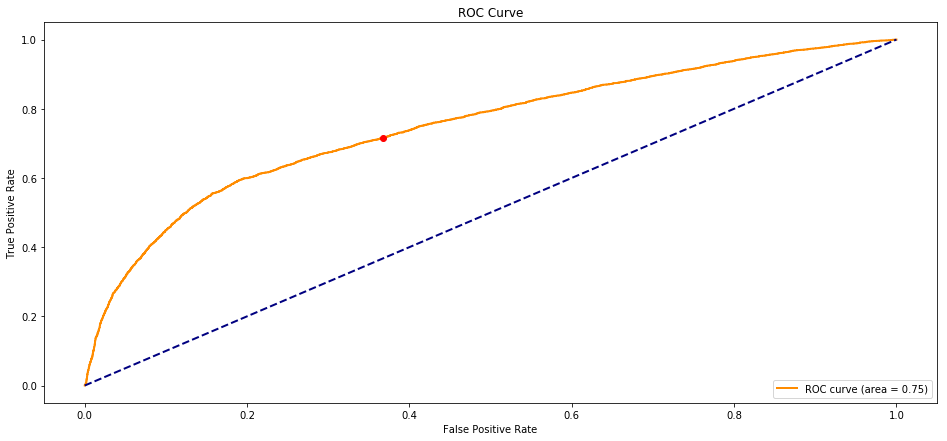

In [199]:
X, y, _, _, _ = retrieve_dataset('ale_kmeans')
clf.fit(X, y)
print(clf.coef_)
plot_roc_curve(clf, 0.25, X, y)

# XGBClassifier
- ale: f1_cv = 0.548 ± 0.021

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold = 0.24
f1_cv = 0.547 ± 0.022
acc_cv = 0.782 ± 0.011
prec_cv = 0.506 ± 0.021
rec_cv = 0.595 ± 0.026


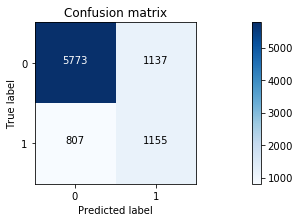

f1 = 0.543
acc = 0.781
prec = 0.504
rec = 0.589


In [169]:
clf = XGBClassifier(seed=r)
_, _ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

Feature ranking:
1. feature BILL_AMT_DEC (0.125731)
2. feature PAY_DEC (0.083333)
3. feature LIMIT_BAL (0.078947)
4. feature BILL_AMT_OCT (0.077485)
5. feature PAY_AMT_DEC (0.070175)
6. feature PAY_AMT_NOV (0.062865)
7. feature PAY_AMT_AUG (0.052632)
8. feature PAY_AMT_JUL (0.049708)
9. feature AGE (0.040936)
10. feature PAY_AMT_SEP (0.039474)
11. feature PAY_JUL (0.038012)
12. feature PAY_AMT_OCT (0.038012)
13. feature EDUCATION (0.030702)
14. feature BILL_AMT_JUL (0.030702)
15. feature BILL_AMT_NOV (0.026316)
16. feature BILL_AMT_AUG (0.026316)
17. feature PAY_NOV (0.021930)
18. feature PAY_SEP (0.020468)
19. feature PAY_OCT (0.019006)
20. feature BILL_AMT_SEP (0.017544)
21. feature MARRIAGE (0.016082)
22. feature PAY_AUG (0.011696)
23. feature CLUSTER_2 (0.008772)
24. feature M (0.007310)
25. feature CLUSTER_0 (0.002924)
26. feature CLUSTER_3 (0.002924)
27. feature F (0.000000)
28. feature CLUSTER_1 (0.000000)


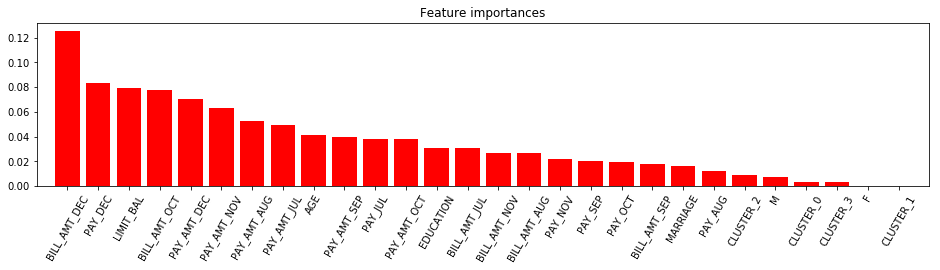

In [170]:
X, y, _, _, _ = retrieve_dataset('ale_kmeans')
forest = clf
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
l_cols = list(X.columns)
labels = [X.columns[i] for i in indices]

# Print the feature ranking
print("Feature ranking:")
for f in np.arange(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, labels[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(np.arange(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(np.arange(X.shape[1]), labels, rotation=60)
plt.xlim([-1, X.shape[1]])
plt.show()

# MEMORY ERROR, Gaussian Process Classifier

In [171]:
if False:
    clf = GaussianProcessClassifier(kernel=None,
                                optimizer='fmin_l_bfgs_b',
                                n_restarts_optimizer=0, 
                                max_iter_predict=100,
                                warm_start=False,
                                copy_X_train=True,
                                random_state=r,
                                #multi_class='one_vs_rest',
                                n_jobs=-1)
    fit_score_add_meta(clf, 'GaussianProcessClassifier', 'baseline')

# Linear Discriminant Analysis

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold = 0.21
f1_cv = 0.524 ± 0.026
acc_cv = 0.781 ± 0.014
prec_cv = 0.504 ± 0.028
rec_cv = 0.546 ± 0.028


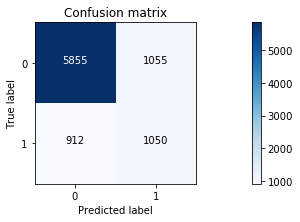

f1 = 0.516
acc = 0.778
prec = 0.499
rec = 0.535


In [175]:
clf = LinearDiscriminantAnalysis(solver='svd', shrinkage=None, n_components=None, store_covariance=False, tol=0.0001)
_, _ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

# Quadratic Discriminant Analysis

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Threshold = 0.3
f1_cv = 0.530 ± 0.022
acc_cv = 0.768 ± 0.013
prec_cv = 0.481 ± 0.024
rec_cv = 0.590 ± 0.025


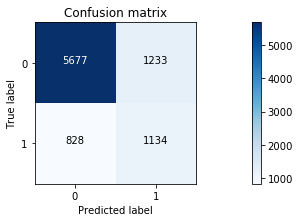

f1 = 0.524
acc = 0.768
prec = 0.479
rec = 0.578


In [174]:
clf = QuadraticDiscriminantAnalysis(reg_param=0.1, store_covariances=False, tol=0.0001)
_, _ = train_cv_test_score_target_pred(clf, 'ale_kmeans')